# Sentiment Analysis

...of all text variables
 I change something to be able to push again

In [75]:
from load_data import *

from helpers import clean_comments
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import collections
from langdetect import detect
from deep_translator import GoogleTranslator

from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud

from textblob import TextBlob


Load and clean the reviews

In [76]:
price, listings, reviews = load_data(image_data=False, drop_id = False)

Data loaded.


D:\Uni\WiSe21-22\Statistical and Deep Learning\DubAir\DubAir\load_data.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings["host_location_country"][fil] = str(i)
d:\uni\wise21-22\statistisches praktikum\venv\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
D:\Uni\WiSe21-22\Statistical and Deep Learning\DubAir\DubAir\load_data.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings["host_location_country"][fil] = str(country_list[i])
D:\Uni\WiSe21-22\Statistical and Deep Learning\Du

Data cleansed.
Imputation done. No NaN's are left in the data.
Further Modifications are done.
Have fun implementing your models.
Data loaded.


D:\Uni\WiSe21-22\Statistical and Deep Learning\DubAir\DubAir\load_data.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings["host_location_country"][fil] = str(i)
d:\uni\wise21-22\statistisches praktikum\venv\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
D:\Uni\WiSe21-22\Statistical and Deep Learning\DubAir\DubAir\load_data.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings["host_location_country"][fil] = str(country_list[i])
D:\Uni\WiSe21-22\Statistical and Deep Learning\Du

Data cleansed.
Imputation done. No NaN's are left in the data.
Further Modifications are done.
Have fun implementing your models.


In [77]:
# reviews_f = reviews["comments"].apply(lambda x: clean_comments(x))
#
# langs = []
# def det_and_trans(review):
#     if len(review) == 0:
#         langs.append(1)
#         return review
#     if not review.islower():
#         langs.append(1)
#         return review
#     det_lan = detect(review)
#     check = det_lan == "en"
#     if not check:
#         translation = GoogleTranslator(source='auto', target='en').translate(review)
#         langs.append(0)
#         return translation
#     else:
#         langs.append(1)
#         return review

# #started at 17:10
# for i in range(len(reviews_f)):
#     reviews_f[i] = det_and_trans(reviews_f[i])
#     print(i)
#
# reviews_df = pd.DataFrame(
#     {"reviews": reviews_f,
#      "lang": langs
#      })
#
#
# reviews_df.to_csv("text_data/trans_reviews.csv")

reviews_f_read = pd.read_csv("text_data/trans_reviews.csv")

reviews_f = reviews_f_read["reviews"]
for i in range(len(reviews_f)):
    if type(reviews_f[i]) == float:
        reviews_f[i] = " "

langs_df = reviews_f_read["lang"]

# Portion of english reviews?
np.mean(langs_df).round(4) * 100

d:\uni\wise21-22\statistisches praktikum\venv\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


86.82

d:\uni\wise21-22\statistisches praktikum\venv\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


86.82

Let's look at some word frequencies

In [78]:
# Word Frequency
def convert(lst):
    return ([i for item in lst for i in item.split()])

all_words_review = convert(reviews_f)

count_word = collections.Counter(all_words_review) #Count word frequency
clean_word_count = pd.DataFrame(count_word.most_common(10),
                             columns=['words', 'count'])

# So let us remove stop words
stop_words = set(stopwords.words(['english']))
# Add some words after analysing
freq_airbnb = ["us", "would", "host", "house", "room", "city", "apartment",
               "location", "dublin", "place", "stay", "de", "also"]
stop_words.update(freq_airbnb)


# View a few words from the set
list(stop_words)[0:10]

['below',
 'city',
 'yourselves',
 'wasn',
 'an',
 'very',
 'have',
 'who',
 'they',
 'over']

['below',
 'city',
 'yourselves',
 'wasn',
 'an',
 'very',
 'have',
 'who',
 'they',
 'over']

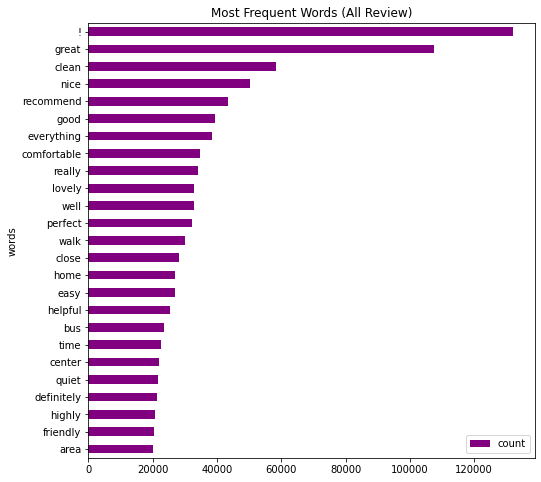

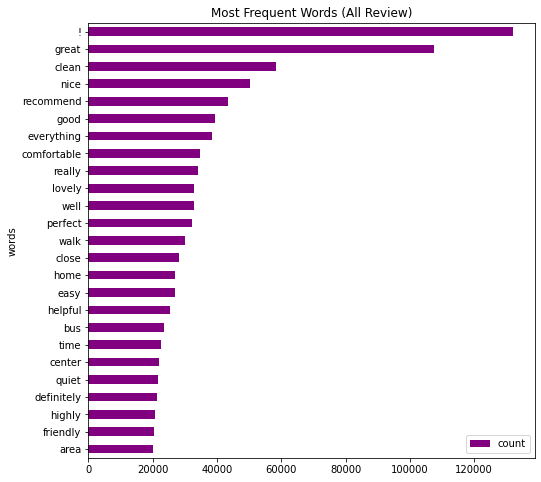

In [79]:
words_review_cleaned = [word for word in all_words_review if word not in stop_words]
words_review_count = collections.Counter(words_review_cleaned)

word_review_count_df = pd.DataFrame(words_review_count.most_common(25),
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
word_review_count_df.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Most Frequent Words (All Review)")

plt.show()

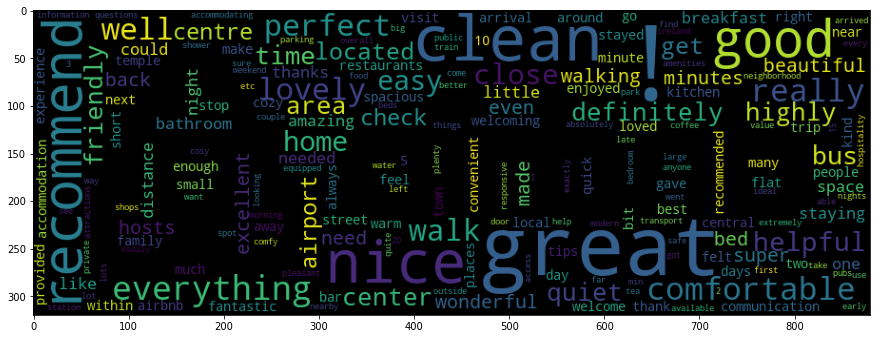

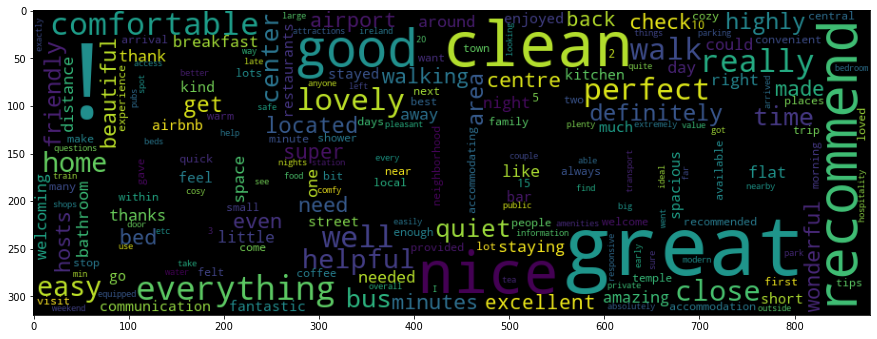

In [80]:
#mask = np.array(Image.open("AirBnB_Logo.png"))
mask = np.array(Image.open("text_data/Airbnb.jpeg"))

wordcloud = WordCloud(width = 1000, height = 500, mask = mask, #background_color="white",
                      ).generate_from_frequencies(words_review_count)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.show()

Now Perform the Sentiment Analysis with NLTK

Neutral, Negativity and Positivity sum up to 1 (like how much of what is in it)
Compound is a weighted normalized (-1,1) score of the sum of the valence -> Sentiment of entire text.

In [81]:

# "no problem(s)" and "no complaints" only was quite negative and special cases do not validate on their own
def no_prob_to_good(review, term):
    if term in review:
        if len(review.split()) < 5:
            review = "We did not have any problems."
    return review

term = "no problem"
for i in range(len(reviews_f)):
    reviews_f[i] = no_prob_to_good(reviews_f[i], term=term)

term = "no complaint"
for i in range(len(reviews_f)):
    reviews_f[i] = no_prob_to_good(reviews_f[i], term=term)

# Polarity Scores
sid = SentimentIntensityAnalyzer()
#sid.constants.SPECIAL_CASE_IDIOMS.update({"no problem" : 1.5, "no problems" : 1.5}) # "no problem(s)" was very negative
pscores = [sid.polarity_scores(comment) for comment in reviews_f]


d:\uni\wise21-22\statistisches praktikum\venv\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
d:\uni\wise21-22\statistisches praktikum\venv\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
d:\uni\wise21-22\statistisches praktikum\venv\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

Histograms of different Polarity Scores

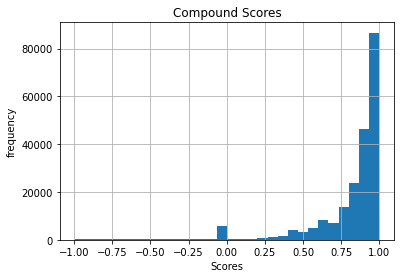

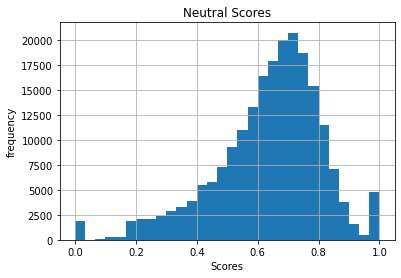

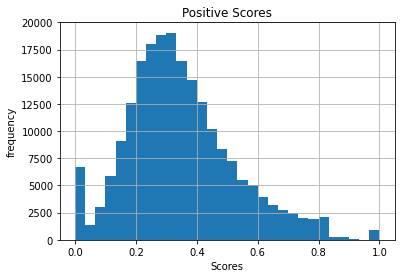

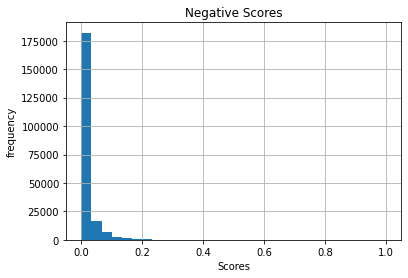

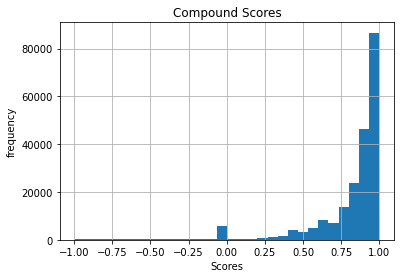

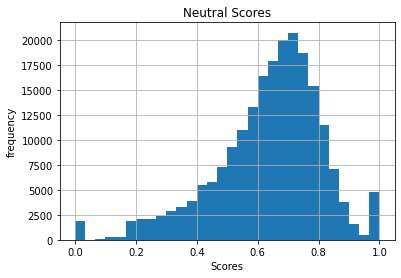

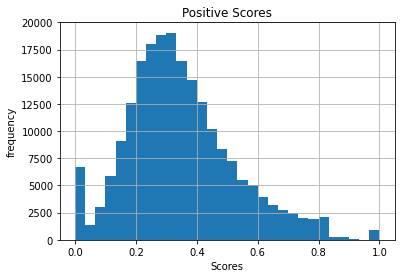

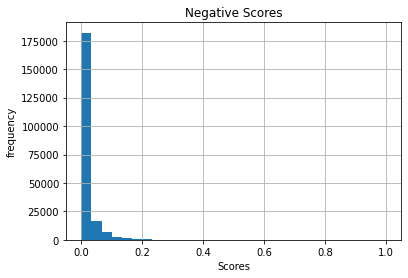

In [82]:
#Histogram plot neutral
pd.Series([score['compound'] for score in pscores]).plot(kind='hist', grid = True, bins = 30)

plt.title('Compound Scores')
plt.xlabel('Scores')
plt.ylabel('frequency')

plt.show()

#Histogram plot neutral
pd.Series([score['neu'] for score in pscores]).plot(kind='hist', grid = True, bins = 30)

plt.title('Neutral Scores')
plt.xlabel('Scores')
plt.ylabel('frequency')

plt.show()

#Histogram plot positive
pd.Series([score['pos'] for score in pscores]).plot(kind='hist', grid = True, bins = 30)

plt.title('Positive Scores')
plt.xlabel('Scores')
plt.ylabel('frequency')

plt.show()

#Histogram plot negative
pd.Series([score['neg'] for score in pscores]).plot(kind='hist', grid = True, bins = 30)

plt.title('Negative Scores')
plt.xlabel('Scores')
plt.ylabel('frequency')

plt.show()

Create a useful dataframe

In [83]:
#Create dataframe for sentiment analysis
scored_reviews = pd.DataFrame()
scored_reviews["listing_id"] = reviews["listing_id"]
scored_reviews["english_review"] = langs_df
scored_reviews['review'] = [r for r in reviews_f]
scored_reviews['compound'] = [score['compound'] for score in pscores]
scored_reviews['negativity'] = [score['neg'] for score in pscores]
scored_reviews['neutrality'] = [score['neu'] for score in pscores]
scored_reviews['positivity'] = [score['pos'] for score in pscores]

worst_reviews = scored_reviews[scored_reviews["negativity"] > 0.7]
worst_reviews["review"]

9704                                   damn
46730                disappointing ambiance
49562                         disappointing
59134                     rude receptionist
66076     uncaring host harassing dishonest
72763      unlovable person lying photos re
120822                            not happy
125674                                  meh
142606                                  meh
143612                                   no
151528                       fire station !
156012                               savage
156084                         savage place
163572                          scam espa o
173879                           ugly place
199648                   poor communication
201838                                avoid
203746                          scam place!
209465                       bad management
Name: review, dtype: object

9704                                   damn
46730                disappointing ambiance
49562                         disappointing
59134                     rude receptionist
66076     uncaring host harassing dishonest
72763      unlovable person lying photos re
120822                            not happy
125674                                  meh
142606                                  meh
143612                                   no
151528                       fire station !
156012                               savage
156084                         savage place
163572                          scam espa o
173879                           ugly place
199648                   poor communication
201838                                avoid
203746                          scam place!
209465                       bad management
Name: review, dtype: object

In [84]:
worst_reviews2 = scored_reviews[scored_reviews["compound"] < -0.97]
worst_reviews2.loc[57642]["review"]

'the apartment is really conveniently located rather big kitchen table it is convenient that 2 toilets the owner has met us and has transferred keys personally also has explained that where in the apartment is though it was very difficult to understand his irish english  but there are also minuses in one of bathrooms under a shower it is impossible to wash as very weak pressure of water because of the strange pump which is installed there the bathtub and a shower are already worn out and damaged we wouldn t pay attention but fastening on a door of a shower was broken off and the owner demands from us compensation it is good that he doesn t ask money for the fused bulb in a corridor it gave us an inconvenience  but the hugest minus is rasplozheny apartments directly over local pub all who go are obliged to know that thursday through sunday you won t sleep to 2 o clock in the morning it is impossible because of noise ! ! ! the owner of the apartment hasn t warned about it 4 nights from e

'the apartment is really conveniently located rather big kitchen table it is convenient that 2 toilets the owner has met us and has transferred keys personally also has explained that where in the apartment is though it was very difficult to understand his irish english  but there are also minuses in one of bathrooms under a shower it is impossible to wash as very weak pressure of water because of the strange pump which is installed there the bathtub and a shower are already worn out and damaged we wouldn t pay attention but fastening on a door of a shower was broken off and the owner demands from us compensation it is good that he doesn t ask money for the fused bulb in a corridor it gave us an inconvenience  but the hugest minus is rasplozheny apartments directly over local pub all who go are obliged to know that thursday through sunday you won t sleep to 2 o clock in the morning it is impossible because of noise ! ! ! the owner of the apartment hasn t warned about it 4 nights from e

In [85]:
best_reviews = scored_reviews[scored_reviews["compound"] > 0.99]
best_reviews["review"][211167]

'wow will only skim the surface !  great hosts with a warm welcome just like the apartment the apartment is situated just off the main house which is architecturally modern and beautiful yet still payed homage to its farming history i might add the landscaped garden and its beautiful apple trees are great to see as you drink your morning coffee and there s a great local country pub only a few hundred meters away which was a great bonus for a quick nightcap the apartment itself is new super clean modern warm and cosy and great value for money'

'wow will only skim the surface !  great hosts with a warm welcome just like the apartment the apartment is situated just off the main house which is architecturally modern and beautiful yet still payed homage to its farming history i might add the landscaped garden and its beautiful apple trees are great to see as you drink your morning coffee and there s a great local country pub only a few hundred meters away which was a great bonus for a quick nightcap the apartment itself is new super clean modern warm and cosy and great value for money'

Easy package TextBlob

TextBlob:
Polarity is Positivity minus Negativity.
Subjectivity describes how subjective the review is.
Maybe very subjective reviews (subjectivity closer to 1) are not as seen as representative.
To adjust for this, correct the polarity by turning around the subjectivity score to then
multiply it with the polarity.

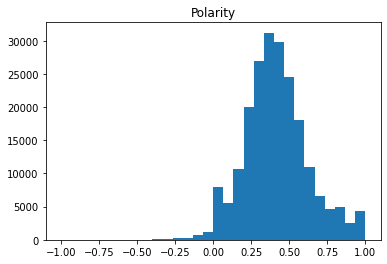

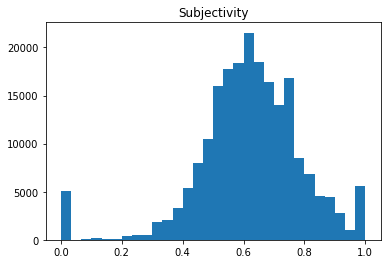

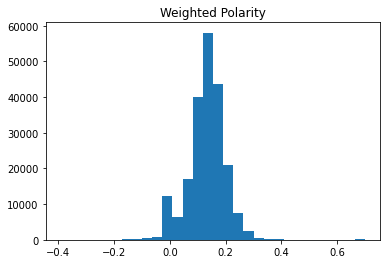

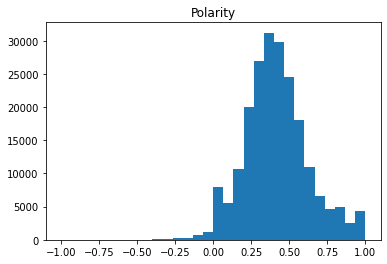

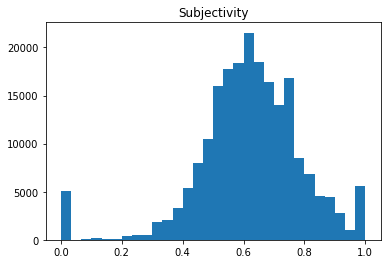

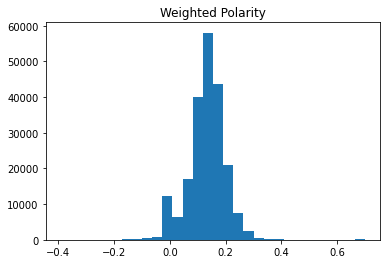

In [86]:
comments_pol = reviews_f.apply(lambda x: TextBlob(x).sentiment[0])
comments_subj = reviews_f.apply(lambda x: TextBlob(x).sentiment[1])

scored_reviews["polarity"] = comments_pol
scored_reviews["subjectivity"] = comments_subj
scored_reviews["weight_polar"] = (0.5 - (scored_reviews["subjectivity"] - 0.5)) * scored_reviews["polarity"]

plt.hist(scored_reviews["polarity"], bins = 30)
plt.title("Polarity")
plt.show()

plt.hist(scored_reviews["subjectivity"], bins = 30)
plt.title("Subjectivity")
plt.show()

plt.hist(scored_reviews["weight_polar"], bins = 30)
plt.title("Weighted Polarity")
plt.show()

# Comparison

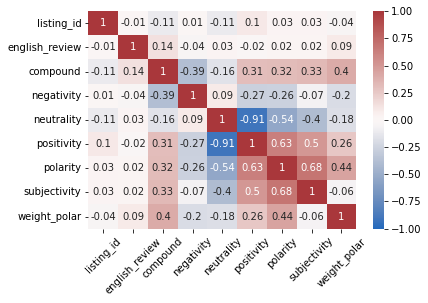

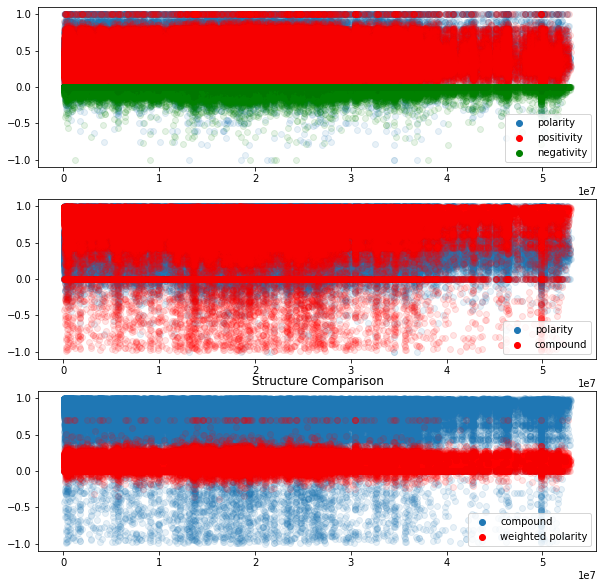

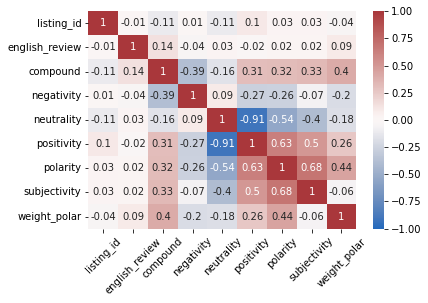

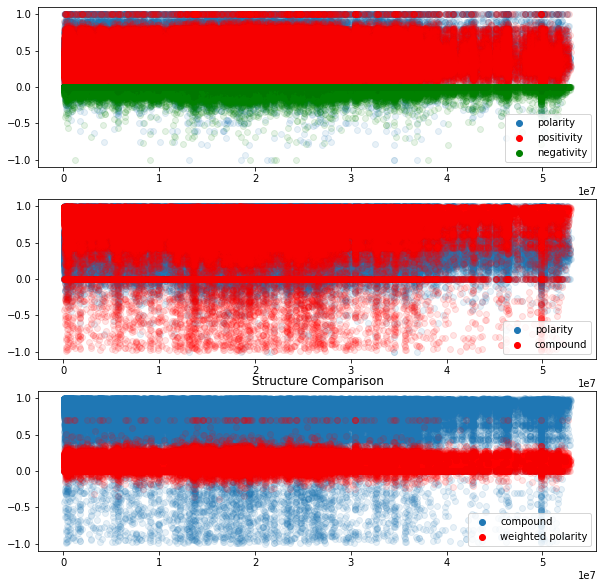

In [87]:
corr_mat = scored_reviews.corr().round(2)
g = sns.heatmap(corr_mat, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment ="center")
plt.show()

fig, axs = plt.subplots(3, figsize=(10,10))
plt.title("Structure Comparison")

axs[0].scatter(scored_reviews['listing_id'], scored_reviews["polarity"], alpha=0.1, label = "polarity")
axs[0].scatter(scored_reviews['listing_id'], scored_reviews["positivity"], c="red",alpha=0.1, label = "positivity")
axs[0].scatter(scored_reviews['listing_id'], -scored_reviews["negativity"], c="green",alpha=0.1, label = "negativity")
leg1 = axs[0].legend(loc = "lower right")
#Disable opacity for legend
for lh in leg1.legendHandles:
    lh.set_alpha(1)

axs[1].scatter(scored_reviews['listing_id'], scored_reviews["polarity"], alpha=0.1, label = "polarity")
axs[1].scatter(scored_reviews['listing_id'], scored_reviews["compound"], c="red",alpha=0.1, label = "compound")
leg2 = axs[1].legend(loc = "lower right")
#Disable opacity for legend
for lh in leg2.legendHandles:
    lh.set_alpha(1)

axs[2].scatter(scored_reviews['listing_id'], scored_reviews["compound"], alpha=0.1, label = "compound")
axs[2].scatter(scored_reviews['listing_id'], scored_reviews["weight_polar"], c="red",alpha=0.1, label = "weighted polarity")
leg2 = axs[2].legend(loc = "lower right")
#Disable opacity for legend
for lh in leg2.legendHandles:
    lh.set_alpha(1)

plt.show()

Add the followings to the dataframe:
- language of review
- length of review
- boolean if review is negative (twice with compound and polarity)

In [88]:
scored_reviews["review_length"] = scored_reviews["review"].apply(lambda x: len(x))
scored_reviews["negative_comp"] = scored_reviews["polarity"] < 0
scored_reviews["negative_polar"] = scored_reviews["polarity"] < 0
del scored_reviews["review"]

Group by listing_id to use it sufficiently.

In [89]:
listings_reviews_min = scored_reviews.groupby(["listing_id"]).min()
listings_reviews_max = scored_reviews.groupby(["listing_id"]).max()
listings_reviews_mean = scored_reviews.groupby(["listing_id"]).mean()
listings_reviews_sum = scored_reviews.groupby(["listing_id"]).sum()

extr_col = listings_reviews_min[["negativity", "polarity"]]
extr_col.columns = ["most_negative", "smallest_polarity"]
extr_col["most_positive"] = listings_reviews_max["positivity"]
extr_col["highest_polarity"] = listings_reviews_max["polarity"]
#extr_col = extr_col.insert(0, listings_reviews_min["listing_id"] 0)

# give all the sums a prefix in their column names
listings_reviews_sum = listings_reviews_sum.add_prefix("sum_of_")

listings_reviews = pd.concat([listings_reviews_mean, extr_col, listings_reviews_sum], axis=1)
listings_reviews.reset_index(inplace=True)

d:\uni\wise21-22\statistisches praktikum\venv\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
d:\uni\wise21-22\statistisches praktikum\venv\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
d:\uni\wise21-22\statistisches praktikum\venv\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [90]:
listings_reviews

,listing_id,english_review,compound,negativity,neutrality,positivity,polarity,subjectivity,weight_polar,review_length,...,sum_of_compound,sum_of_negativity,sum_of_neutrality,sum_of_positivity,sum_of_polarity,sum_of_subjectivity,sum_of_weight_polar,sum_of_review_length,sum_of_negative_comp,sum_of_negative_polar
0,44077,0.859031,0.886258,0.009793,0.670132,0.311251,0.386916,0.603425,0.134704,323.744493,...,201.1806,2.223,152.120,70.654,87.829998,136.977479,30.577704,73490,0,0
1,85148,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,86.000000,...,0.0000,0.000,1.000,0.000,0.000000,0.000000,0.000000,86,0,0
2,85156,0.829670,0.903634,0.007324,0.656236,0.336429,0.412874,0.620905,0.142510,314.010989,...,164.4613,1.333,119.435,61.230,75.143158,113.004755,25.936743,57150,1,1
3,159889,0.894569,0.814857,0.013380,0.657185,0.326230,0.378445,0.600504,0.129934,256.952077,...,255.0503,4.188,205.699,102.110,118.453389,187.957605,40.669355,80426,4,4
4,162809,0.843750,0.850852,0.011899,0.627295,0.360833,0.421916,0.610597,0.143604,253.572917,...,245.0455,3.427,180.661,103.920,121.511855,175.851961,41.357912,73029,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5542,52850962,1.000000,0.811125,0.005750,0.620750,0.373500,0.240822,0.435191,0.099353,312.000000,...,3.2445,0.023,2.483,1.494,0.963288,1.740765,0.397411,1248,0,0
5543,52879135,1.000000,0.421500,0.000000,0.682000,0.318000,0.400000,0.650000,0.140000,33.000000,...,0.4215,0.000,0.682,0.318,0.400000,0.650000,0.140000,33,0,0
5544,52898729,1.000000,0.932400,0.009750,0.548500,0.442000,0.396038,0.685840,0.123272,204.500000,...,3.7296,0.039,2.194,1.768,1.584152,2.743359,0.493086,818,0,0
5545,52959358,1.000000,0.954900,0.000000,0.714000,0.286000,0.278088,0.678571,0.089385,265.000000,...,0.9549,0.000,0.714,0.286,0.278088,0.678571,0.089385,265,0,0


,listing_id,english_review,compound,negativity,neutrality,positivity,polarity,subjectivity,weight_polar,review_length,...,sum_of_compound,sum_of_negativity,sum_of_neutrality,sum_of_positivity,sum_of_polarity,sum_of_subjectivity,sum_of_weight_polar,sum_of_review_length,sum_of_negative_comp,sum_of_negative_polar
0,44077,0.859031,0.886258,0.009793,0.670132,0.311251,0.386916,0.603425,0.134704,323.744493,...,201.1806,2.223,152.120,70.654,87.829998,136.977479,30.577704,73490,0,0
1,85148,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,86.000000,...,0.0000,0.000,1.000,0.000,0.000000,0.000000,0.000000,86,0,0
2,85156,0.829670,0.903634,0.007324,0.656236,0.336429,0.412874,0.620905,0.142510,314.010989,...,164.4613,1.333,119.435,61.230,75.143158,113.004755,25.936743,57150,1,1
3,159889,0.894569,0.814857,0.013380,0.657185,0.326230,0.378445,0.600504,0.129934,256.952077,...,255.0503,4.188,205.699,102.110,118.453389,187.957605,40.669355,80426,4,4
4,162809,0.843750,0.850852,0.011899,0.627295,0.360833,0.421916,0.610597,0.143604,253.572917,...,245.0455,3.427,180.661,103.920,121.511855,175.851961,41.357912,73029,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5542,52850962,1.000000,0.811125,0.005750,0.620750,0.373500,0.240822,0.435191,0.099353,312.000000,...,3.2445,0.023,2.483,1.494,0.963288,1.740765,0.397411,1248,0,0
5543,52879135,1.000000,0.421500,0.000000,0.682000,0.318000,0.400000,0.650000,0.140000,33.000000,...,0.4215,0.000,0.682,0.318,0.400000,0.650000,0.140000,33,0,0
5544,52898729,1.000000,0.932400,0.009750,0.548500,0.442000,0.396038,0.685840,0.123272,204.500000,...,3.7296,0.039,2.194,1.768,1.584152,2.743359,0.493086,818,0,0
5545,52959358,1.000000,0.954900,0.000000,0.714000,0.286000,0.278088,0.678571,0.089385,265.000000,...,0.9549,0.000,0.714,0.286,0.278088,0.678571,0.089385,265,0,0


# Check for Correlations

All the Variables wanted are now in the DataFrame listings_reviews.
Especially the grouping and the use of two packages might result in high correlations.

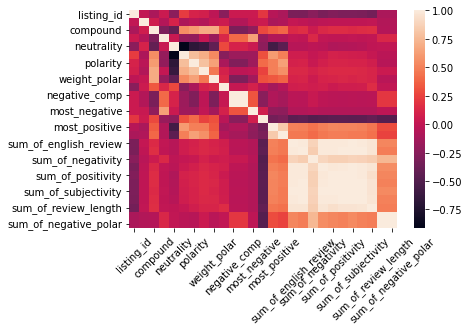

sum_of_negative_comp   sum_of_negative_polar    1.000000
negative_comp          negative_polar           1.000000
sum_of_polarity        sum_of_subjectivity      0.997615
sum_of_compound        sum_of_weight_polar      0.997493
sum_of_positivity      sum_of_polarity          0.996510
sum_of_polarity        sum_of_weight_polar      0.996436
sum_of_english_review  sum_of_subjectivity      0.996286
sum_of_positivity      sum_of_subjectivity      0.995948
sum_of_compound        sum_of_subjectivity      0.995760
sum_of_subjectivity    sum_of_weight_polar      0.995510
sum_of_neutrality      sum_of_subjectivity      0.995376
sum_of_compound        sum_of_polarity          0.995247
sum_of_english_review  sum_of_weight_polar      0.994911
                       sum_of_compound          0.994841
                       sum_of_polarity          0.994219
sum_of_neutrality      sum_of_weight_polar      0.994104
sum_of_english_review  sum_of_neutrality        0.994037
sum_of_compound        sum_of_n

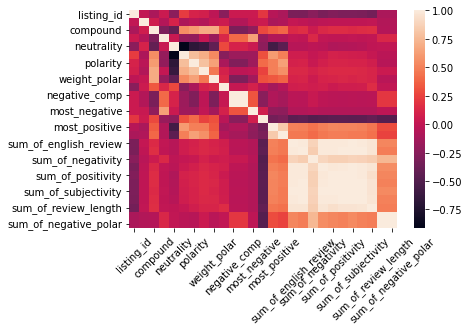

sum_of_negative_comp   sum_of_negative_polar    1.000000
negative_comp          negative_polar           1.000000
sum_of_polarity        sum_of_subjectivity      0.997615
sum_of_compound        sum_of_weight_polar      0.997493
sum_of_positivity      sum_of_polarity          0.996510
sum_of_polarity        sum_of_weight_polar      0.996436
sum_of_english_review  sum_of_subjectivity      0.996286
sum_of_positivity      sum_of_subjectivity      0.995948
sum_of_compound        sum_of_subjectivity      0.995760
sum_of_subjectivity    sum_of_weight_polar      0.995510
sum_of_neutrality      sum_of_subjectivity      0.995376
sum_of_compound        sum_of_polarity          0.995247
sum_of_english_review  sum_of_weight_polar      0.994911
                       sum_of_compound          0.994841
                       sum_of_polarity          0.994219
sum_of_neutrality      sum_of_weight_polar      0.994104
sum_of_english_review  sum_of_neutrality        0.994037
sum_of_compound        sum_of_n

In [91]:
corr_mat = listings_reviews.corr().round(2)
g = sns.heatmap(corr_mat)#, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment ="center")
plt.show()

# We see some high correlations in the sum area. Let's list it.
c = listings_reviews.corr().abs()
# Set the diagonal to 0, so we do not look at self correlations
sol = (c.where(np.triu(np.ones(c.shape), k=1).astype(np.bool))
                  .stack()
                  .sort_values(ascending=False))

sol[sol > 0.9]

Especially the sums are correlated a lot;
also compound and polarity are perfectly correlated
Keep NLTK over Textblob due to more widespread
Concering Sums:
Keep Polarity over Subjectivity due to everything being a subjective experience
Keep compound over weighted polarity, since second one is constructed by us
Keep Polarity over Positivity since it includes Positivity
Delete Sum of Review length since it is no intuitive value and correlates with three other variables


In [92]:
listings_reviews = listings_reviews.drop(["sum_of_negative_polar", "negative_polar",
                                          "sum_of_subjectivity", "sum_of_weight_polar",
                                          "sum_of_positivity", "sum_of_polarity",
                                          "sum_of_review_length", "sum_of_neutrality"],
                                           axis = 1)

c = listings_reviews.corr().abs()
# Set the diagonal to 0, so we do not look at self correlations
sol = (c.where(np.triu(np.ones(c.shape), k=1).astype(np.bool))
                  .stack()
                  .sort_values(ascending=False))

# Only neutrality and positivity remains but not sure, so keep it.
# Correlation of sum of english makes no sense, so keep it.
sol[sol > 0.7]

sum_of_english_review  sum_of_compound         0.994841
neutrality             positivity              0.908603
sum_of_english_review  sum_of_negativity       0.877016
sum_of_compound        sum_of_negativity       0.854134
most_positive          highest_polarity        0.830089
polarity               subjectivity            0.794189
positivity             polarity                0.773230
sum_of_negativity      sum_of_negative_comp    0.738781
positivity             subjectivity            0.703966
dtype: float64

sum_of_english_review  sum_of_compound         0.994841
neutrality             positivity              0.908603
sum_of_english_review  sum_of_negativity       0.877016
sum_of_compound        sum_of_negativity       0.854134
most_positive          highest_polarity        0.830089
polarity               subjectivity            0.794189
positivity             polarity                0.773230
sum_of_negativity      sum_of_negative_comp    0.738781
positivity             subjectivity            0.703966
dtype: float64

# Further Texts
Which are: ["name", "host_name", "description", "neighborhood_overview", "host_about"]
Name - "Name of the listing"
host_name - "Name of the host. Usually just the first name(s)."
description: "Detailed description of the listing"
neighbourhood_overview: "Host's description of the neighbourhood"
host_about: "Description about the host"

All these variables are written by the host (or naturally given, like their name).
It might have an effect how much effort to shine or how much love they put in the
descriptions. So the length could be a proper variable.

Try sentiments at description, neighbourhood_overview and host_about.


In [93]:
text_col = ["name", "host_name", "description", "neighborhood_overview", "host_about"]

listings["name_length"] = listings["name"].apply(lambda x: len(x))
listings["description_length"] = listings["description"].apply(lambda x: len(x))
listings["neighborhood_overview_length"] = listings["neighborhood_overview"].apply(lambda x: len(x))
listings["host_about_length"] = listings["host_about"].apply(lambda x: len(x))


# Sentiment Analysis
of "description", "neighborhood_overview", "host_about"

In [94]:
# Translation and language used by the Host
# list_name = listings["name"].apply(lambda x: clean_comments(x))
# descr = listings["description"].apply(lambda x: clean_comments(x))
# neigh_over = listings["neighborhood_overview"].apply(lambda x: clean_comments(x))
# host_ab = listings["host_about"].apply(lambda x: clean_comments(x))


# # check if all are english
# langs = []
# for i in range(len(listings)):
#     list_name[i] = det_and_trans(list_name[i])
#     descr[i] = det_and_trans(descr[i])
#     neigh_over[i] = det_and_trans(neigh_over[i])
#     host_ab[i] = det_and_trans(host_ab[i])
#     print(i)
#
# list_name_lang = langs[::4]
# descr_lang = langs[1::4]
# neigh_over_lang = langs[2::4]
# host_ab_lang = langs[3::4]
#
# eng_host = []
# for i in range(len(descr_lang)):
#     lang_sum = list_name_lang[i] + descr_lang[i] + neigh_over_lang[i] + host_ab_lang[i]
#     if lang_sum <= 1:
#         eng_host.append(0)
#     else:
#         eng_host.append(1)
#
#
# host_lang = pd.DataFrame(
#     {"list_name": list_name,
#      "descr": descr,
#      "neigh_over": neigh_over,
#      "host_ab": host_ab,
#      "eng_host": eng_host
#      })
#
# host_lang.to_csv("host_lang.csv")

host_lang = pd.read_csv("text_data/host_lang.csv")

for i in range(len(host_lang)):
    if type(host_lang["list_name"][i]) == float:
        host_lang["list_name"][i] = " "
    if type(host_lang["descr"][i]) == float:
        host_lang["descr"][i] = " "
    if type(host_lang["neigh_over"][i]) == float:
        host_lang["neigh_over"][i] = " "
    if type(host_lang["host_ab"][i]) == float:
        host_lang["host_ab"][i] = " "

host_lang

d:\uni\wise21-22\statistisches praktikum\venv\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
d:\uni\wise21-22\statistisches praktikum\venv\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
d:\uni\wise21-22\statistisches praktikum\venv\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
d:\uni\wise21-22\statistisches prakti

,Unnamed: 0,list_name,descr,neigh_over,host_ab,eng_host
0,0,cosy comfortable irish cottage twin,our house was built in 1937 when there was ple...,i like our neighbourhood as there is no shorta...,i am a friendly outgoing irishwoman who loves ...,1
1,1,cosy comfortable irish cottage 1 double bed,our cottage is a charming light filled cottage...,i love dundrum and its surrounding areas br / ...,i am a friendly outgoing irishwoman who loves ...,1
2,2,friendly single room,washing can be done at a cost of 5 per load br...,plenty of buses into the city and the area is ...,used to host students and now i am looking for...,1
3,3,5 5 miles south of dublin city ^,a nice place to relax after the bustle of the ...,close to the sea hill walks and the city via b...,i live here on the third floor of my house the...,1
4,4,p draig pearse apt kilmainham,don t just visit dublin experience dublin in a...,enjoy a walk along the grand canal or just obs...,i m gr inne originally from co kildare and rai...,1
...,...,...,...,...,...,...
6835,6835,stylish 1 bed in dublin 4 close to all amenities,the apartment is located within a stunning geo...,dublin city,wake up in the comfort of your own home where ...,1
6836,6836,lovely non shared single bedroom,we are a very easy going couple the apartment ...,dublin city,,1
6837,6837,adorable 1 bedroom and 1 bathroom apartment,this large newly refurbished apartment is with...,dublin city,wake up in the comfort of your own home where ...,1
6838,6838,lovely 1 bed apartment in a ideally location,this bright newly refurbished apartment is wit...,dublin city,wake up in the comfort of your own home where ...,1


d:\uni\wise21-22\statistisches praktikum\venv\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
d:\uni\wise21-22\statistisches praktikum\venv\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
d:\uni\wise21-22\statistisches praktikum\venv\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
d:\uni\wise21-22\statistisches prakti

,Unnamed: 0,list_name,descr,neigh_over,host_ab,eng_host
0,0,cosy comfortable irish cottage twin,our house was built in 1937 when there was ple...,i like our neighbourhood as there is no shorta...,i am a friendly outgoing irishwoman who loves ...,1
1,1,cosy comfortable irish cottage 1 double bed,our cottage is a charming light filled cottage...,i love dundrum and its surrounding areas br / ...,i am a friendly outgoing irishwoman who loves ...,1
2,2,friendly single room,washing can be done at a cost of 5 per load br...,plenty of buses into the city and the area is ...,used to host students and now i am looking for...,1
3,3,5 5 miles south of dublin city ^,a nice place to relax after the bustle of the ...,close to the sea hill walks and the city via b...,i live here on the third floor of my house the...,1
4,4,p draig pearse apt kilmainham,don t just visit dublin experience dublin in a...,enjoy a walk along the grand canal or just obs...,i m gr inne originally from co kildare and rai...,1
...,...,...,...,...,...,...
6835,6835,stylish 1 bed in dublin 4 close to all amenities,the apartment is located within a stunning geo...,dublin city,wake up in the comfort of your own home where ...,1
6836,6836,lovely non shared single bedroom,we are a very easy going couple the apartment ...,dublin city,,1
6837,6837,adorable 1 bedroom and 1 bathroom apartment,this large newly refurbished apartment is with...,dublin city,wake up in the comfort of your own home where ...,1
6838,6838,lovely 1 bed apartment in a ideally location,this bright newly refurbished apartment is wit...,dublin city,wake up in the comfort of your own home where ...,1


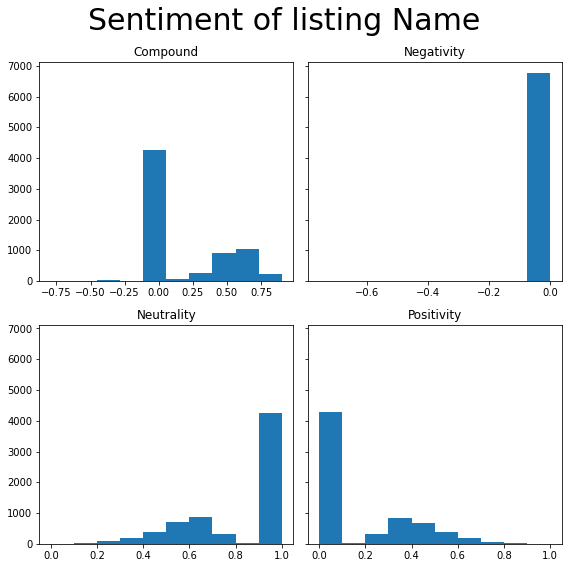

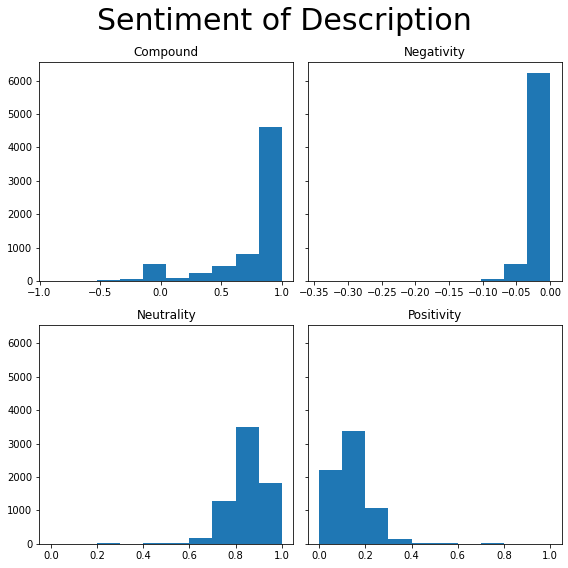

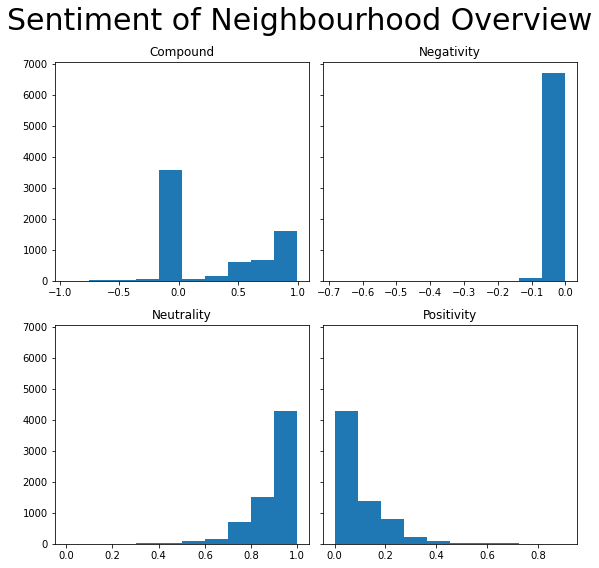

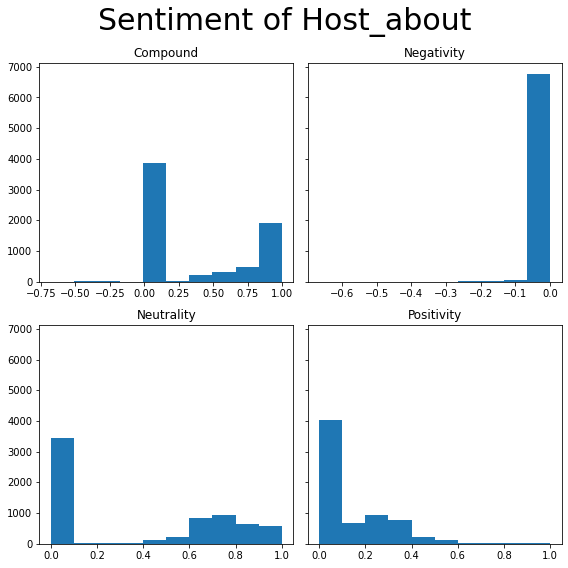

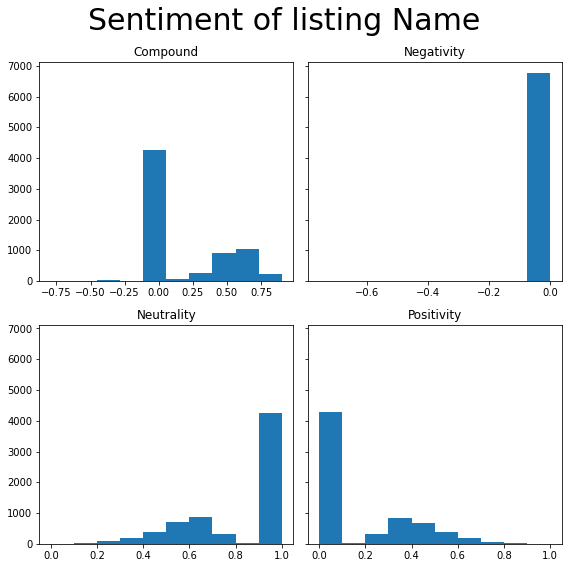

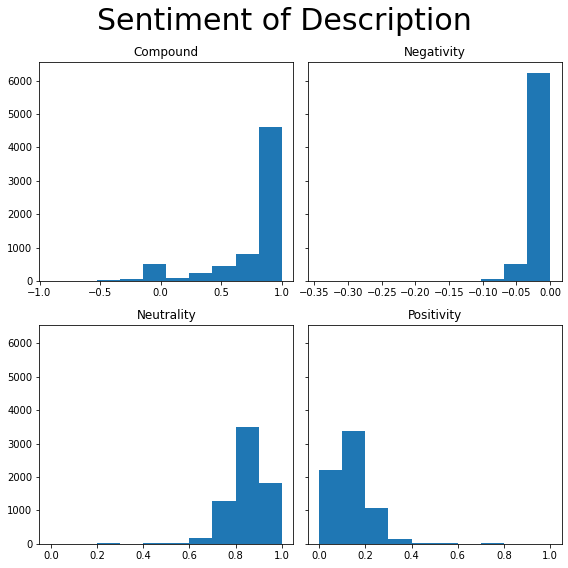

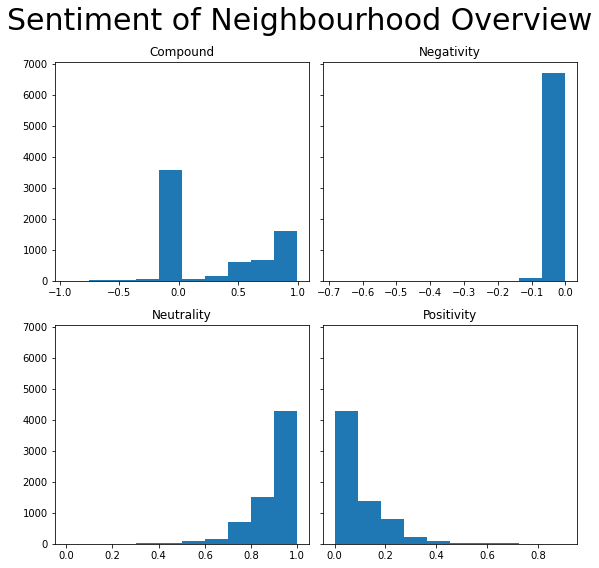

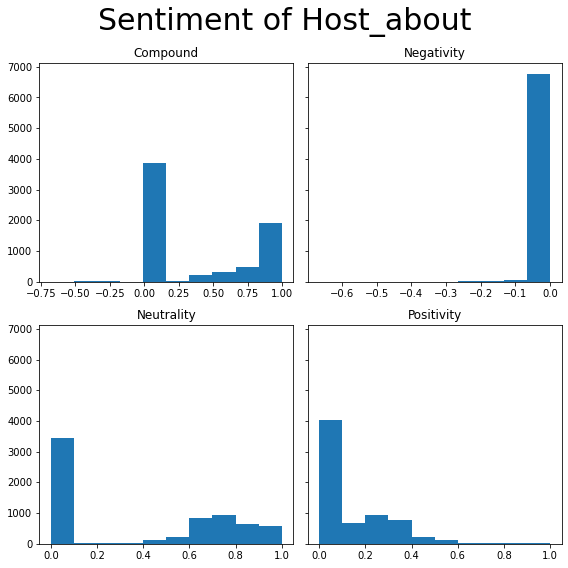

In [95]:
#Sentiment Analysis

# Polarity Scores
sid = SentimentIntensityAnalyzer()
pscores_name = [sid.polarity_scores(comment) for comment in host_lang["list_name"]]
pscores_descr = [sid.polarity_scores(comment) for comment in host_lang["descr"]]
pscores_neigh_over = [sid.polarity_scores(comment) for comment in host_lang["neigh_over"]]
pscores_host_ab = [sid.polarity_scores(comment) for comment in host_lang["host_ab"]]

host_sent = pd.DataFrame()
host_sent["id"] = listings["id"]
host_sent["english_writing_host"] = host_lang["eng_host"]
host_sent['name'] = [r for r in host_lang["list_name"]]
host_sent['descr'] = [r for r in host_lang["descr"]]
host_sent['neigh_over'] = [r for r in host_lang["neigh_over"]]
host_sent['host_ab'] = [r for r in host_lang["host_ab"]]
host_sent['compound_name'] = [score['compound'] for score in pscores_name]
host_sent['negativity_name'] = [score['neg'] for score in pscores_name]
host_sent['neutrality_name'] = [score['neu'] for score in pscores_name]
host_sent['positivity_name'] = [score['pos'] for score in pscores_name]
host_sent['compound_descr'] = [score['compound'] for score in pscores_descr]
host_sent['negativity_descr'] = [score['neg'] for score in pscores_descr]
host_sent['neutrality_descr'] = [score['neu'] for score in pscores_descr]
host_sent['positivity_descr'] = [score['pos'] for score in pscores_descr]
host_sent['compound_neigh_over'] = [score['compound'] for score in pscores_neigh_over]
host_sent['negativity_neigh_over'] = [score['neg'] for score in pscores_neigh_over]
host_sent['neutrality_neigh_over'] = [score['neu'] for score in pscores_neigh_over]
host_sent['positivity_neigh_over'] = [score['pos'] for score in pscores_neigh_over]
host_sent['compound_host_ab'] = [score['compound'] for score in pscores_host_ab]
host_sent['negativity_host_ab'] = [score['neg'] for score in pscores_host_ab]
host_sent['neutrality_host_ab'] = [score['neu'] for score in pscores_host_ab]
host_sent['positivity_host_ab'] = [score['pos'] for score in pscores_host_ab]

# set figure
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharey=True)
fig.suptitle('Sentiment of listing Name', fontsize=30)
# plot to different axes
ax[0,0].hist(host_sent['compound_name'])
ax[0,0].set_title("Compound")
ax[0,1].hist(-host_sent['negativity_name'])
ax[0,1].set_title("Negativity")
ax[1,0].hist(host_sent['neutrality_name'])
ax[1,0].set_title("Neutrality")
ax[1,1].hist(host_sent['positivity_name'])
ax[1,1].set_title("Positivity")

plt.tight_layout()
plt.show()

# set figure
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharey=True)
fig.suptitle('Sentiment of Description', fontsize=30)
# plot to different axes
ax[0,0].hist(host_sent['compound_descr'])
ax[0,0].set_title("Compound")
ax[0,1].hist(-host_sent['negativity_descr'])
ax[0,1].set_title("Negativity")
ax[1,0].hist(host_sent['neutrality_descr'])
ax[1,0].set_title("Neutrality")
ax[1,1].hist(host_sent['positivity_descr'])
ax[1,1].set_title("Positivity")

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharey=True)
fig.suptitle('Sentiment of Neighbourhood Overview', fontsize=30)
# plot to different axes
ax[0,0].hist(host_sent['compound_neigh_over'])
ax[0,0].set_title("Compound")
ax[0,1].hist(-host_sent['negativity_neigh_over'])
ax[0,1].set_title("Negativity")
ax[1,0].hist(host_sent['neutrality_neigh_over'])
ax[1,0].set_title("Neutrality")
ax[1,1].hist(host_sent['positivity_neigh_over'])
ax[1,1].set_title("Positivity")

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharey=True)
fig.suptitle('Sentiment of Host_about', fontsize=30)
# plot to different axes
ax[0,0].hist(host_sent['compound_host_ab'])
ax[0,0].set_title("Compound")
ax[0,1].hist(-host_sent['negativity_host_ab'])
ax[0,1].set_title("Negativity")
ax[1,0].hist(host_sent['neutrality_host_ab'])
ax[1,0].set_title("Neutrality")
ax[1,1].hist(host_sent['positivity_host_ab'])
ax[1,1].set_title("Positivity")

plt.tight_layout()
plt.show()

In [96]:
# What are considered Negative Listing Names?
bad_names = host_sent["name"][host_sent['compound_name'] < -0.1]
bad_names = bad_names.reset_index()
for i in bad_names["name"]:
    print(i)

funky studio loft near city centre
no longer hosting
self contained studio/bedsit no 4
self contained studio/bedsit no 1
self contained studio/bedsit no 2
self contained studio/bedsit no 3
detached house overlooking park
single bedroom for lone traveller
detached luxury home dublin suburb
mayor street lower penthouse ifsc
new modern cosy 40sqm 430sqft detached flat
double room with fire place in wooden indoor house
modern stylish 2 bed apartament in d8
detached victorian house near dublin city
cosy funky in the heart of dublin city !
king room w/parking near airport no kitchen
private room w/parking near airport no kitchen
private room/parking near airport no kitchen
lower bed with attached bathroom
nice room in d8
wrong one
funky double bedroom in city centre d6 rathmines
double room to get lost explore heart of dublin
this property is no longer available
funky town house in old city
private room in detached family home sandyford d16
dublin finglas not so easy going house
no 122
dubli

In [97]:
# What are considered Negative Descriptions?
bad_descriptions = host_sent["descr"][host_sent['compound_descr'] < -0.5]
bad_descriptions = bad_descriptions.reset_index()
for i in bad_descriptions["descr"]:
    print(i)

the flat is across from st patricks cathedral it s in the heart of dublin close to shopping resturants bars and all the sights dublin has to offer temple bar area is a short walk from the flat br / br / b the space /b br / when you arrive at the flat that is the last time you will need a taxi everything is in walking distance i just placed triple glaze windows last month so very quite at night br / br / b guest access /b br / no guest arrivals after 9pm at the flat ! br / br / b other things to note /b br / no arrival after 9pm
architecturally designed open plan cottage 5 minutes walk from the famous forty foot bathing area in sandycove and glasthule village dublin city is 20 min away by dart/overground train sandycove/ glasthule dart station is right beside the house br / br / b the space /b br / in the wintertime you can be in bed and look at the fire at the same time ! in summer you can go for a swim in the sea before cycling to work br / br / b guest access /b br / will confirm key

In [98]:
# What are considered Negative Neighbourhood Overview?
bad_overview = host_sent["neigh_over"][host_sent['compound_neigh_over'] < -0.7]
bad_overview = bad_overview.reset_index()
for i in bad_overview["neigh_over"]:
    print(i)

the complex is located at the point village a neighborhood in the old dublin docklands the area has suffered a huge transformation in the last years one block from the apartment you can find the gibson hotel the point village shopping center as of today only the cinemas and coffee shops are open the luas tram station that takes you in no time to o connell street and 3arena concert venue there are also a number of new additions to the neighborhood as the new head offices of the central bank of ireland just one block away
my apartment is located in a quiet apartment block while still providing a direct link into the heart of the city it is situated directly across from phoenix park which is known as one of the largest designed landscapes in a european city and it contains one of the oldest zoos in the world br / br / located beside phoenix park you have the museum of decorative arts and history displaying weaponry furniture silvery and examples of folk life in ireland also within a 15 mi

In [99]:
# What are considered Negative Neighbourhood Overview?
bad_abouts = host_sent["host_ab"][host_sent['compound_host_ab'] < 0]
bad_abouts = bad_abouts.reset_index()
for i in bad_abouts["host_ab"]:
    print(i)


i am a working professional divorced no children i love travel and meeting new people i live with my dog play badminton in my spare time love all music except trad/country my motto in life is fool me once shame on you fool me twice shame on me
i am a working professional divorced no children i love travel and meeting new people i live with my dog play badminton in my spare time love all music except trad/country my motto in life is fool me once shame on you fool me twice shame on me
living and working in dublin ireland i am interested in photography particularly film work sailing and following soccer and rugby may you be a half hour in heaven before the devil knows you re dead ! ! !
i m not good at describing myself
my name is patricia have been living in clontarf for many years i am a medical fitness professional specialising in persons with heart lung and cancer illnesses i also have been involved with the charity to children with love for the past 20 years i play golf badly !
hi the

# Textblob

In [100]:
host_sent["name_polarity"] =  host_sent["name"].apply(lambda x: TextBlob(x).sentiment[0])
host_sent["name_subjectivity"] =  host_sent["name"].apply(lambda x: TextBlob(x).sentiment[1])
host_sent["name_weight_polar"] = (0.5 - (host_sent["name_subjectivity"] - 0.5)) * host_sent["name_polarity"]

host_sent["descr_polarity"] =  host_sent["descr"].apply(lambda x: TextBlob(x).sentiment[0])
host_sent["descr_subjectivity"] =  host_sent["descr"].apply(lambda x: TextBlob(x).sentiment[1])
host_sent["descr_weight_polar"] = (0.5 - (host_sent["descr_subjectivity"] - 0.5)) * host_sent["descr_polarity"]

host_sent["neigh_over_polarity"] =  host_sent["neigh_over"].apply(lambda x: TextBlob(x).sentiment[0])
host_sent["neigh_over_subjectivity"] =  host_sent["neigh_over"].apply(lambda x: TextBlob(x).sentiment[1])
host_sent["neigh_over_weight_polar"] = (0.5 - (host_sent["neigh_over_subjectivity"] - 0.5)) * host_sent["neigh_over_polarity"]

host_sent["host_ab_polarity"] =  host_sent["host_ab"].apply(lambda x: TextBlob(x).sentiment[0])
host_sent["host_ab_subjectivity"] =  host_sent["host_ab"].apply(lambda x: TextBlob(x).sentiment[1])
host_sent["host_ab_weight_polar"] = (0.5 - (host_sent["host_ab_subjectivity"] - 0.5)) * host_sent["host_ab_polarity"]

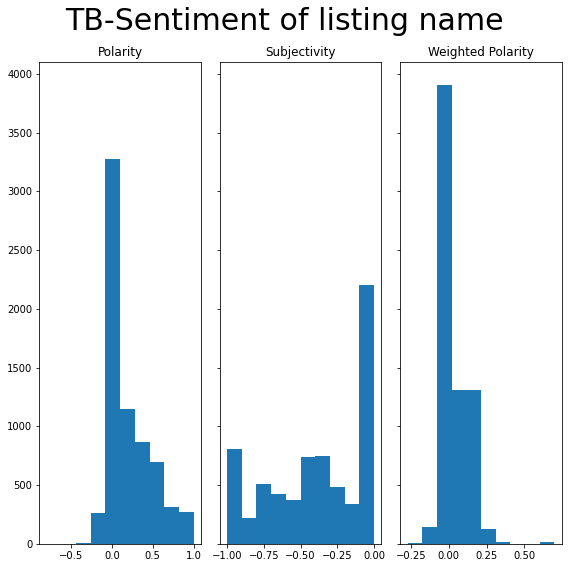

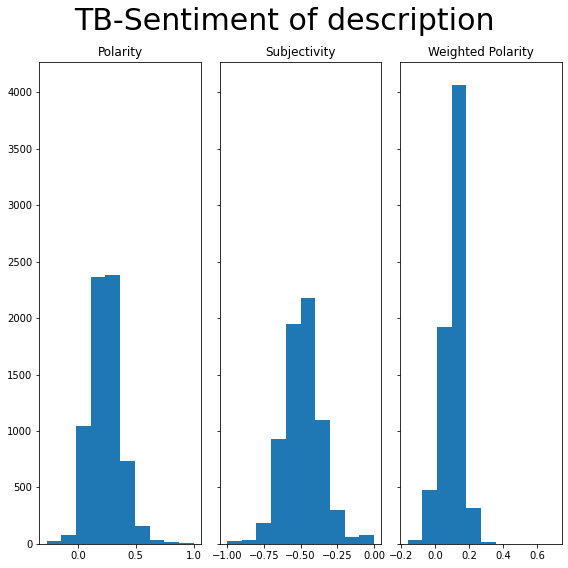

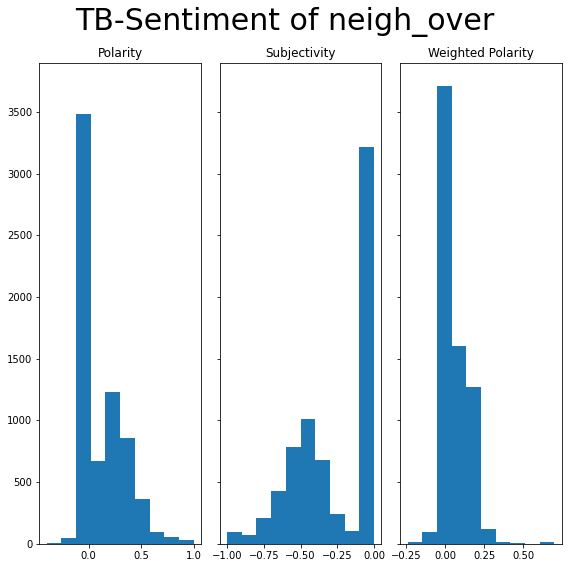

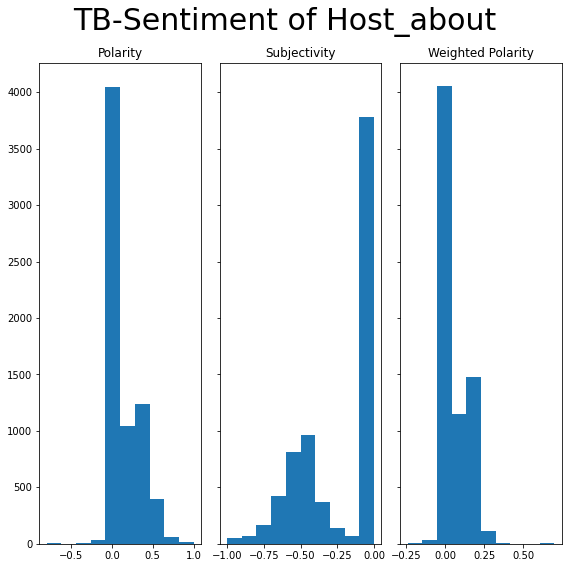

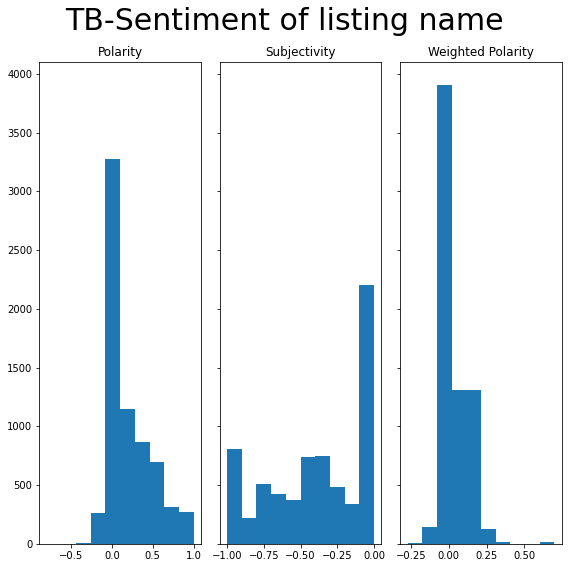

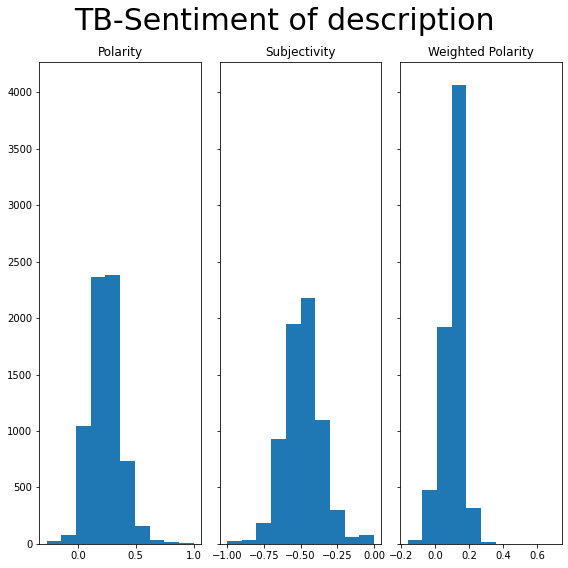

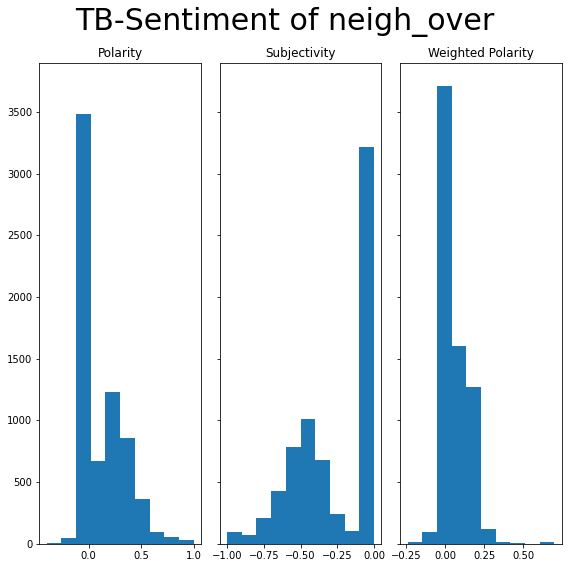

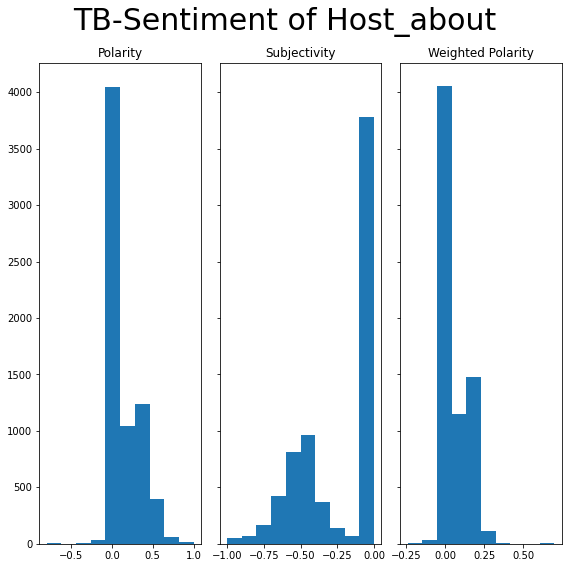

In [101]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 8), sharey=True)
fig.suptitle('TB-Sentiment of listing name', fontsize=30)
# plot to different axes
ax[0].hist(host_sent['name_polarity'])
ax[0].set_title("Polarity")
ax[1].hist(-host_sent['name_subjectivity'])
ax[1].set_title("Subjectivity")
ax[2].hist(host_sent['name_weight_polar'])
ax[2].set_title("Weighted Polarity")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 8), sharey=True)
fig.suptitle('TB-Sentiment of description', fontsize=30)
# plot to different axes
ax[0].hist(host_sent['descr_polarity'])
ax[0].set_title("Polarity")
ax[1].hist(-host_sent['descr_subjectivity'])
ax[1].set_title("Subjectivity")
ax[2].hist(host_sent['descr_weight_polar'])
ax[2].set_title("Weighted Polarity")
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 8), sharey=True)
fig.suptitle('TB-Sentiment of neigh_over', fontsize=30)
# plot to different axes
ax[0].hist(host_sent['neigh_over_polarity'])
ax[0].set_title("Polarity")
ax[1].hist(-host_sent['neigh_over_subjectivity'])
ax[1].set_title("Subjectivity")
ax[2].hist(host_sent['neigh_over_weight_polar'])
ax[2].set_title("Weighted Polarity")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 8), sharey=True)
fig.suptitle('TB-Sentiment of Host_about', fontsize=30)
# plot to different axes
ax[0].hist(host_sent['host_ab_polarity'])
ax[0].set_title("Polarity")
ax[1].hist(-host_sent['host_ab_subjectivity'])
ax[1].set_title("Subjectivity")
ax[2].hist(host_sent['host_ab_weight_polar'])
ax[2].set_title("Weighted Polarity")
plt.tight_layout()
plt.show()

In [102]:
# We see typical high correlation between neutrality and positivity
c = host_sent.loc[:,"compound_descr":].corr().abs()
# Set the diagonal to 0, so we do not look at self correlations
sol = (c.where(np.triu(np.ones(c.shape), k=1).astype(np.bool))
                  .stack()
                  .sort_values(ascending=False))

sol[sol > 0.9]


neutrality_neigh_over  positivity_neigh_over    0.980490
neutrality_descr       positivity_descr         0.928818
dtype: float64

neutrality_neigh_over  positivity_neigh_over    0.980490
neutrality_descr       positivity_descr         0.928818
dtype: float64

In [103]:
host_sent = host_sent.drop(["neutrality_neigh_over"],
                            axis = 1)
host_sent

,id,english_writing_host,name,descr,neigh_over,host_ab,compound_name,negativity_name,neutrality_name,positivity_name,...,name_weight_polar,descr_polarity,descr_subjectivity,descr_weight_polar,neigh_over_polarity,neigh_over_subjectivity,neigh_over_weight_polar,host_ab_polarity,host_ab_subjectivity,host_ab_weight_polar
0,44077,1,cosy comfortable irish cottage twin,our house was built in 1937 when there was ple...,i like our neighbourhood as there is no shorta...,i am a friendly outgoing irishwoman who loves ...,0.5106,0.0,0.548,0.452,...,0.120000,0.343609,0.632331,0.126334,0.299603,0.618651,0.114253,0.258766,0.445292,0.143540
1,85156,1,cosy comfortable irish cottage 1 double bed,our cottage is a charming light filled cottage...,i love dundrum and its surrounding areas br / ...,i am a friendly outgoing irishwoman who loves ...,0.5106,0.0,0.602,0.398,...,0.097778,0.207644,0.439348,0.116416,0.415395,0.577368,0.175559,0.258766,0.445292,0.143540
2,159889,1,friendly single room,washing can be done at a cost of 5 per load br...,plenty of buses into the city and the area is ...,used to host students and now i am looking for...,0.4939,0.0,0.385,0.615,...,0.097577,0.296746,0.492857,0.150493,0.366667,0.650000,0.128333,0.000000,0.866667,0.000000
3,162809,1,5 5 miles south of dublin city ^,a nice place to relax after the bustle of the ...,close to the sea hill walks and the city via b...,i live here on the third floor of my house the...,0.0000,0.0,1.000,0.000,...,0.000000,0.328393,0.517029,0.158604,0.187500,0.416667,0.109375,0.136880,0.350000,0.088972
4,165828,1,p draig pearse apt kilmainham,don t just visit dublin experience dublin in a...,enjoy a walk along the grand canal or just obs...,i m gr inne originally from co kildare and rai...,0.0000,0.0,1.000,0.000,...,0.000000,0.268075,0.503948,0.132979,0.250000,0.412500,0.146875,0.375000,0.514706,0.181985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6835,53159314,1,stylish 1 bed in dublin 4 close to all amenities,the apartment is located within a stunning geo...,dublin city,wake up in the comfort of your own home where ...,0.0000,0.0,1.000,0.000,...,0.000000,0.479167,0.683333,0.151736,0.000000,0.000000,0.000000,0.440000,0.700000,0.132000
6836,53160612,1,lovely non shared single bedroom,we are a very easy going couple the apartment ...,dublin city,,0.7351,0.0,0.326,0.674,...,0.110969,0.563333,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6837,53177641,1,adorable 1 bedroom and 1 bathroom apartment,this large newly refurbished apartment is with...,dublin city,wake up in the comfort of your own home where ...,0.4939,0.0,0.556,0.444,...,0.000000,0.407581,0.615390,0.156760,0.000000,0.000000,0.000000,0.440000,0.700000,0.132000
6838,53178928,1,lovely 1 bed apartment in a ideally location,this bright newly refurbished apartment is wit...,dublin city,wake up in the comfort of your own home where ...,0.7650,0.0,0.377,0.623,...,0.087500,0.301475,0.598386,0.121077,0.000000,0.000000,0.000000,0.440000,0.700000,0.132000


,id,english_writing_host,name,descr,neigh_over,host_ab,compound_name,negativity_name,neutrality_name,positivity_name,...,name_weight_polar,descr_polarity,descr_subjectivity,descr_weight_polar,neigh_over_polarity,neigh_over_subjectivity,neigh_over_weight_polar,host_ab_polarity,host_ab_subjectivity,host_ab_weight_polar
0,44077,1,cosy comfortable irish cottage twin,our house was built in 1937 when there was ple...,i like our neighbourhood as there is no shorta...,i am a friendly outgoing irishwoman who loves ...,0.5106,0.0,0.548,0.452,...,0.120000,0.343609,0.632331,0.126334,0.299603,0.618651,0.114253,0.258766,0.445292,0.143540
1,85156,1,cosy comfortable irish cottage 1 double bed,our cottage is a charming light filled cottage...,i love dundrum and its surrounding areas br / ...,i am a friendly outgoing irishwoman who loves ...,0.5106,0.0,0.602,0.398,...,0.097778,0.207644,0.439348,0.116416,0.415395,0.577368,0.175559,0.258766,0.445292,0.143540
2,159889,1,friendly single room,washing can be done at a cost of 5 per load br...,plenty of buses into the city and the area is ...,used to host students and now i am looking for...,0.4939,0.0,0.385,0.615,...,0.097577,0.296746,0.492857,0.150493,0.366667,0.650000,0.128333,0.000000,0.866667,0.000000
3,162809,1,5 5 miles south of dublin city ^,a nice place to relax after the bustle of the ...,close to the sea hill walks and the city via b...,i live here on the third floor of my house the...,0.0000,0.0,1.000,0.000,...,0.000000,0.328393,0.517029,0.158604,0.187500,0.416667,0.109375,0.136880,0.350000,0.088972
4,165828,1,p draig pearse apt kilmainham,don t just visit dublin experience dublin in a...,enjoy a walk along the grand canal or just obs...,i m gr inne originally from co kildare and rai...,0.0000,0.0,1.000,0.000,...,0.000000,0.268075,0.503948,0.132979,0.250000,0.412500,0.146875,0.375000,0.514706,0.181985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6835,53159314,1,stylish 1 bed in dublin 4 close to all amenities,the apartment is located within a stunning geo...,dublin city,wake up in the comfort of your own home where ...,0.0000,0.0,1.000,0.000,...,0.000000,0.479167,0.683333,0.151736,0.000000,0.000000,0.000000,0.440000,0.700000,0.132000
6836,53160612,1,lovely non shared single bedroom,we are a very easy going couple the apartment ...,dublin city,,0.7351,0.0,0.326,0.674,...,0.110969,0.563333,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6837,53177641,1,adorable 1 bedroom and 1 bathroom apartment,this large newly refurbished apartment is with...,dublin city,wake up in the comfort of your own home where ...,0.4939,0.0,0.556,0.444,...,0.000000,0.407581,0.615390,0.156760,0.000000,0.000000,0.000000,0.440000,0.700000,0.132000
6838,53178928,1,lovely 1 bed apartment in a ideally location,this bright newly refurbished apartment is wit...,dublin city,wake up in the comfort of your own home where ...,0.7650,0.0,0.377,0.623,...,0.087500,0.301475,0.598386,0.121077,0.000000,0.000000,0.000000,0.440000,0.700000,0.132000


# host_name as the last thing

Idea: Check for Racism

In [104]:
names = pd.read_csv("text_data/name-census-top-100.csv", sep =";")
host_names = listings["host_name"]

# due to https://en.wikipedia.org/wiki/Western_Europe#UN_geoscheme_classification
west_europe = ["Austria", "Belgium", "Denmark", "Finland", "France",
               "Germany", "Ireland", "Jersey","Luxembourg", "Netherlands",
               "Norway", "Sweden", "Switzerland", "United Kingdom"]
south_europe = ["Cyprus", "Greece", "Italy", "Portugal", "Spain"]
east_europe = ["Albania", "Belarus", "Bulgaria", "Bosnia and Herzegovina", "Croatia",
               "Czech Republic", "Hungary", "Kosovo", "Latvia", "Lithuania", "Macedonia",
               "Poland", "Romania", "Russia", "Serbia", "Slovakia", "Slovenia", "Ukraine"]

# https://www.worldmap-knowledge.com/articles/the-four-regions-of-asia.html
central_asia = ["Kazakhstan"]
east_asia = ["China", "Hong Kong", "Japan", "South Korea", "Taiwan"]
south_asia = ["Afghanistan", "Bangladesh", "India", "Iran", "Nepal", "Pakistan"]
south_east_asia = ["Indonesia", "Malaysia", "Philippines", "Singapore",
                   "Thailand", "Vietnam"]
west_asia = ["Azerbaijan", "Georgia", "Iraq", "Israel", "Jordan", "Kuwait", "Lebanon",
             "Palestine", "Qatar", "Saudi Arabia", "Syria", "Turkey", "United Arab Emirates"]

oceania = ["Australia", "New Zealand"]

# due to https://de.wikipedia.org/wiki/Geographie_Afrikas
north_africa = ["Algeria", "Egypt", "Morocco", "Sudan", "Tunisia"]
west_africa = ["Burkina Faso", "Ghana", "Ivory Coast", "Liberia", "Nigeria", "Senegal"]
central_africa = ["Angola", "Cameroon"]
east_africa = ["Kenya", "Mayotte", "Zimbabwe", "Somalia", "Tanzania", "Uganda", "Zambia"]

# by feeling and regionale und politische UNterteilung: https://de.wikipedia.org/wiki/Nordamerika
north_america = ["Canada", "United States"]
central_america = ["Bermuda", "Mexico"]
south_central_america = ["Costa Rica", "Dominican Republic", "El Salvador", "Guatemala",
                         "Honduras", "Jamaica", "Nicaragua", "Panama", "Saint Vincent"]

# due to https://de.wikipedia.org/wiki/S%C3%BCdamerika politische Geografie
amazonas = ["Bolivia", "Brazil", "Colombia", "Ecuador", "Peru", "Venezuela"]
conosur = ["Argentina", "Chile", "Paraguay", "Uruguay"]

regions = ["west_europe", "south_europe", "east_europe",
           "central_asia", "east_asia", "south_asia", "south_east_asia",
           "west_asia", "oceania", "north_africa", "west_africa",
           "central_africa", "east_africa", "north_america", "central_america",
           "south_central_america", "amazonas", "conosur", "rare"]

where_df = pd.DataFrame(0, index=np.arange(len(listings)), columns=regions)

# Now real loop
for i in range(len(host_names)):
    und_df = names[host_names.loc[i].split()[0] == names["Name"]][["Country name", "Country Rank"]]
    if len(und_df) == 0:
        where_df.at[i, "rare"] = 1
    elif any(country in west_europe for country in und_df["Country name"]):
        where_df.at[i, "west_europe"] = 1
    else:
        con = und_df.loc[und_df["Country Rank"].idxmax(),]["Country name"]
        if any(country in south_europe for country in und_df["Country name"]):
            where_df.at[i, "south_europe"] = 1
        elif any(country in east_europe for country in und_df["Country name"]):
            where_df.at[i, "east_europe"] = 1
        elif any(country in central_asia for country in und_df["Country name"]):
            where_df.at[i, "central_asia"] = 1
        elif any(country in east_asia for country in und_df["Country name"]):
            where_df.at[i, "east_asia"] = 1
        elif any(country in south_asia for country in und_df["Country name"]):
            where_df.at[i, "south_asia"] = 1
        elif any(country in south_east_asia for country in und_df["Country name"]):
            where_df.at[i, "south_east_asia"] = 1
        elif any(country in west_asia for country in und_df["Country name"]):
            where_df.at[i, "west_asia"] = 1
        elif any(country in oceania for country in und_df["Country name"]):
            where_df.at[i, "oceania"] = 1
        elif any(country in north_africa for country in und_df["Country name"]):
            where_df.at[i, "north_africa"] = 1
        elif any(country in west_africa for country in und_df["Country name"]):
            where_df.at[i, "west_africa"] = 1
        elif any(country in central_africa for country in und_df["Country name"]):
            where_df.at[i, "central_africa"] = 1
        elif any(country in east_africa for country in und_df["Country name"]):
            where_df.at[i, "east_africa"] = 1
        elif any(country in north_america for country in und_df["Country name"]):
            where_df.at[i, "north_america"] = 1
        elif any(country in central_america for country in und_df["Country name"]):
            where_df.at[i, "central_america"] = 1
        elif any(country in south_central_america for country in und_df["Country name"]):
            where_df.at[i, "south_central_america"] = 1
        elif any(country in amazonas for country in und_df["Country name"]):
            where_df.at[i, "amazonas"] = 1
        elif any(country in conosur for country in und_df["Country name"]):
            where_df.at[i, "conosur"] = 1
        else:
            where_df.at[i, "rare"] = 1

# Do we have enough examples for all regions?
# Not really, so combine some
where_df.sum()

west_europe              4038
south_europe              276
east_europe               381
central_asia                3
east_asia                  95
south_asia                103
south_east_asia            62
west_asia                  84
oceania                     6
north_africa               21
west_africa                42
central_africa              9
east_africa                40
north_america               3
central_america             5
south_central_america      18
amazonas                   12
conosur                     8
rare                     1634
dtype: int64

west_europe              4038
south_europe              276
east_europe               381
central_asia                3
east_asia                  95
south_asia                103
south_east_asia            62
west_asia                  84
oceania                     6
north_africa               21
west_africa                42
central_africa              9
east_africa                40
north_america               3
central_america             5
south_central_america      18
amazonas                   12
conosur                     8
rare                     1634
dtype: int64

We found very small groups. One possibility would be grouping by continent.
But wouldn't we expect racism against people potentially not coming from a
Western Culture?
Found categories here https://en.wikipedia.org/wiki/Western_world - and used further sources as mentioned.

In [105]:
#https://en.wikipedia.org/wiki/Arab_world
arab = ['Iraq', 'Jordan', 'Kuwait', 'Lebanon', 'Palestine', 'Qatar',
        'Saudi Arabia', 'Syria','United Arab Emirates'] + north_africa
# https://en.wikipedia.org/wiki/Africa but without arab
africa = west_africa + central_africa + east_africa
# https://en.wikipedia.org/wiki/Latin_America
latin_america = ["Mexico"] + south_central_america + amazonas + conosur
# https://en.wikipedia.org/wiki/Western_world#Modern_definitions
west = ['Bermuda', 'Bulgaria', 'Croatia', 'Czech Republic', 'Hungary', 'Latvia',
        'Lithuania', 'Poland', 'Romania', 'Slovakia', 'Slovenia'] \
       + oceania + north_america + west_europe + south_europe
# https://en.wikipedia.org/wiki/Eastern_Orthodoxy_by_country
eastern_europe = ['Albania', 'Belarus', 'Bosnia and Herzegovina',
            'Kosovo', 'Macedonia', 'Russia', 'Serbia', 'Ukraine']
asia = central_asia + east_asia + south_asia + south_east_asia \
       + ['Azerbaijan', 'Georgia', 'Israel',  'Turkey']


cult_regions = ["arab", "africa", "asia", "eastern_europe", "latin_america", "west", "rare"]

where_df_cult = pd.DataFrame(0, index=np.arange(len(listings)), columns=cult_regions)

# Now real loop
for i in range(len(host_names)):
    und_df = names[host_names.loc[i].split()[0] == names["Name"]][["Country name", "Country Rank"]]
    if len(und_df) == 0:
        where_df_cult.at[i, "rare"] = 1
    elif any(country in west for country in und_df["Country name"]):
        where_df_cult.at[i, "west"] = 1
    else:
        con = und_df.loc[und_df["Country Rank"].idxmax(),]["Country name"]
        if any(country in arab for country in und_df["Country name"]):
            where_df_cult.at[i, "arab"] = 1
        elif any(country in africa for country in und_df["Country name"]):
            where_df_cult.at[i, "africa"] = 1
        elif any(country in asia for country in und_df["Country name"]):
            where_df_cult.at[i, "asia"] = 1
        elif any(country in eastern_europe for country in und_df["Country name"]):
            where_df_cult.at[i, "eastern_europe"] = 1
        elif any(country in latin_america for country in und_df["Country name"]):
            where_df_cult.at[i, "latin_america"] = 1
        else:
            where_df_cult.at[i, "rare"] = 1

# Let's this categorisation
where_df_cult.sum()

arab               113
africa             144
asia               184
eastern_europe      23
latin_america       41
west              4701
rare              1634
dtype: int64

arab               113
africa             144
asia               184
eastern_europe      23
latin_america       41
west              4701
rare              1634
dtype: int64

In [106]:
where_df_cult = where_df_cult.add_prefix('host_name_sounds_')
where_df_cult.columns

Index(['host_name_sounds_arab', 'host_name_sounds_africa',
       'host_name_sounds_asia', 'host_name_sounds_eastern_europe',
       'host_name_sounds_latin_america', 'host_name_sounds_west',
       'host_name_sounds_rare'],
      dtype='object')

Index(['host_name_sounds_arab', 'host_name_sounds_africa',
       'host_name_sounds_asia', 'host_name_sounds_eastern_europe',
       'host_name_sounds_latin_america', 'host_name_sounds_west',
       'host_name_sounds_rare'],
      dtype='object')

# Now add all to the listing object

In [107]:
listings = listings.drop(text_col, axis = 1)
listings = pd.merge(listings, host_sent, on = "id", how="left")
listings = pd.concat([listings, where_df_cult], axis = 1)

listings_reviews.columns = ["id", 'english_review', 'compound', 'negativity', 'neutrality', 'positivity',
       'review_length', 'polarity', 'subjectivity', 'weight_polar',
       'negative_comp', 'most_negative', 'smallest_polarity', 'most_positive',
       'highest_polarity', 'sum_of_english_review', 'sum_of_compound',
       'sum_of_negativity', 'sum_of_negative_comp']

listings = pd.merge(listings, listings_reviews, on = "id", how = "left")
listings

,id,host_since,host_listings_count,latitude,longitude,accommodates,beds,minimum_nights,maximum_nights,availability_30,...,weight_polar,negative_comp,most_negative,smallest_polarity,most_positive,highest_polarity,sum_of_english_review,sum_of_compound,sum_of_negativity,sum_of_negative_comp
0,44077,4112,3.0,53.291780,-6.257920,2,2.0,3,1125,0,...,323.744493,0.000000,0.0,0.000000,0.906,1.00,195.0,201.1806,2.223,0.0
1,85156,4112,3.0,53.292090,-6.256240,2,1.0,3,21,0,...,314.010989,0.005495,0.0,-0.003333,0.798,0.89,151.0,164.4613,1.333,1.0
2,159889,3783,0.0,53.390270,-6.235470,1,1.0,2,21,5,...,256.952077,0.012780,0.0,-0.160714,1.000,1.00,280.0,255.0503,4.188,4.0
3,162809,3780,2.0,53.283260,-6.191880,6,4.0,1,12,6,...,253.572917,0.010417,0.0,-0.166667,1.000,1.00,243.0,245.0455,3.427,3.0
4,165828,3777,5.0,53.337440,-6.323630,5,3.0,4,365,11,...,414.620000,0.060000,0.0,-0.156713,0.648,0.75,40.0,40.7946,0.775,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6835,53159314,5,0.0,53.327305,-6.246794,2,1.0,14,35,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6836,53160612,2107,0.0,53.401550,-6.163366,1,1.0,1,365,25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6837,53177641,5,0.0,53.328041,-6.246490,2,1.0,14,35,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6838,53178928,5,0.0,53.327274,-6.248867,2,1.0,14,35,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,id,host_since,host_listings_count,latitude,longitude,accommodates,beds,minimum_nights,maximum_nights,availability_30,...,weight_polar,negative_comp,most_negative,smallest_polarity,most_positive,highest_polarity,sum_of_english_review,sum_of_compound,sum_of_negativity,sum_of_negative_comp
0,44077,4112,3.0,53.291780,-6.257920,2,2.0,3,1125,0,...,323.744493,0.000000,0.0,0.000000,0.906,1.00,195.0,201.1806,2.223,0.0
1,85156,4112,3.0,53.292090,-6.256240,2,1.0,3,21,0,...,314.010989,0.005495,0.0,-0.003333,0.798,0.89,151.0,164.4613,1.333,1.0
2,159889,3783,0.0,53.390270,-6.235470,1,1.0,2,21,5,...,256.952077,0.012780,0.0,-0.160714,1.000,1.00,280.0,255.0503,4.188,4.0
3,162809,3780,2.0,53.283260,-6.191880,6,4.0,1,12,6,...,253.572917,0.010417,0.0,-0.166667,1.000,1.00,243.0,245.0455,3.427,3.0
4,165828,3777,5.0,53.337440,-6.323630,5,3.0,4,365,11,...,414.620000,0.060000,0.0,-0.156713,0.648,0.75,40.0,40.7946,0.775,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6835,53159314,5,0.0,53.327305,-6.246794,2,1.0,14,35,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6836,53160612,2107,0.0,53.401550,-6.163366,1,1.0,1,365,25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6837,53177641,5,0.0,53.328041,-6.246490,2,1.0,14,35,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6838,53178928,5,0.0,53.327274,-6.248867,2,1.0,14,35,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Save for loading data

In [108]:
# listings_reviews.to_csv("text_data/listings_reviews.csv")
# host_sent.to_csv("text_data/host_sent.csv")
# where_df_cult.to_csv("text_data/host_name.csv")

Imputations:

In [109]:
listings.isna().sum()[listings.isna().sum() >0]

english_review           1405
compound                 1405
negativity               1405
neutrality               1405
positivity               1405
review_length            1405
polarity                 1405
subjectivity             1405
weight_polar             1405
negative_comp            1405
most_negative            1405
smallest_polarity        1405
most_positive            1405
highest_polarity         1405
sum_of_english_review    1405
sum_of_compound          1405
sum_of_negativity        1405
sum_of_negative_comp     1405
dtype: int64

english_review           1405
compound                 1405
negativity               1405
neutrality               1405
positivity               1405
review_length            1405
polarity                 1405
subjectivity             1405
weight_polar             1405
negative_comp            1405
most_negative            1405
smallest_polarity        1405
most_positive            1405
highest_polarity         1405
sum_of_english_review    1405
sum_of_compound          1405
sum_of_negativity        1405
sum_of_negative_comp     1405
dtype: int64

In [110]:
listings["english_review"].fillna(np.nanmean(listings["english_review"]), inplace=True)
listings["compound"].fillna(0, inplace=True)
listings["negativity"].fillna(0, inplace=True)
listings["neutrality"].fillna(1, inplace=True)
listings["positivity"].fillna(0, inplace=True)
listings["review_length"].fillna(0, inplace=True)
listings["polarity"].fillna(0, inplace=True)
listings["subjectivity"].fillna(0, inplace=True)
listings["weight_polar"].fillna(0, inplace=True)
listings["negative_comp"].fillna(0, inplace=True)
listings["most_negative"].fillna(0, inplace=True)
listings["smallest_polarity"].fillna(0, inplace=True)
listings["most_positive"].fillna(0, inplace=True)
listings["highest_polarity"].fillna(0, inplace=True)
listings["sum_of_english_review"].fillna(0, inplace=True)
listings["sum_of_compound"].fillna(0, inplace=True)
listings["sum_of_negativity"].fillna(0, inplace=True)
listings["sum_of_negative_comp"].fillna(0, inplace=True)

In [111]:
listings.isna().sum()[listings.isna().sum() >0]

Series([], dtype: int64)

Series([], dtype: int64)